In [ ]:
import pyspark.sql.functions as f
from pyspark.sql.window import Window

from spark_builder import build_spark_session
from transformations import trasform_bronze_silver
import matplotlib.pyplot as plt

spark = build_spark_session()

In [2]:
# trasform_bronze_silver(spark)

In [3]:
bronze_df = spark.read.csv("./bronze/*.csv")
silver_df = spark.read.parquet("./silver")

In [4]:
silver_df.show()

+-------------------+----------+----------+-------------------+--------------------+-------+-------+---------+--------------------+
|         event_time|event_type|product_id|        category_id|       category_code|  brand|  price|  user_id|        user_session|
+-------------------+----------+----------+-------------------+--------------------+-------+-------+---------+--------------------+
|2019-11-09 17:32:27|      cart|  19700004|2053013559104766575|                null|kabrita|  37.77|539704497|                null|
|2019-11-09 19:15:24|      cart|   1005083|2053013555631882655|electronics.smart...|  honor| 566.27|568843390|                null|
|2019-11-09 15:58:06|      view|   1004307|2053013555631882655|electronics.smart...|  honor| 308.63|569353390|000001d5-f8f8-4e4...|
|2019-11-02 15:29:04|      view|  12300059|2053013556311359947|construction.tool...|  bosch|  69.17|513196170|00000510-834a-498...|
|2019-11-05 03:26:06|      view|  13200514|2053013557192163841|furniture.bed

In [5]:
print(bronze_df.count())
print(silver_df.count())

109950745
19985297


In [6]:
silver_df = spark.read.parquet("./silver").filter("event_time is not null") # прибрати це перед показом

counts_per_day = (
    silver_df.withColumn("event_date", f.to_date(f.col("event_time")))
    .groupBy(f.col("event_date"))
    .count()
    .select(f.col("event_date"), f.col("count").alias("events_count"))
    .orderBy("event_date")
)

pd_counts_per_day = counts_per_day.toPandas()

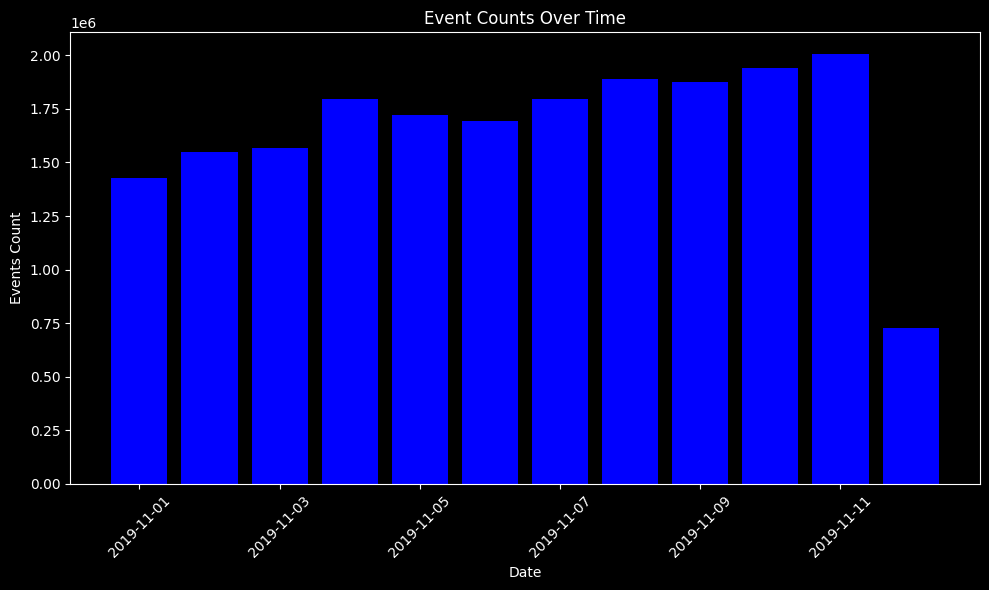

In [7]:
plt.figure(figsize=(10, 6))
plt.bar(
    pd_counts_per_day["event_date"], pd_counts_per_day["events_count"], color="blue"
)
plt.title("Event Counts Over Time")
plt.xlabel("Date")
plt.ylabel("Events Count")
plt.xticks(rotation=45)
# plt.grid(axis="y")
plt.tight_layout()
plt.show()

In [8]:
most_popular_categories = (
    silver_df.filter("category_code is not null")
    .groupBy("category_code")
    .count()
    .orderBy("count", ascending=False)
)

most_popular_categories.show()

+--------------------+-------+
|       category_code|  count|
+--------------------+-------+
|electronics.smart...|5028934|
|  computers.notebook| 615195|
|electronics.video.tv| 607007|
|  electronics.clocks| 596309|
|       apparel.shoes| 557611|
|electronics.audio...| 500072|
|appliances.kitche...| 405028|
|appliances.kitche...| 399758|
|appliances.enviro...| 394527|
|   computers.desktop| 215784|
|furniture.living_...| 184730|
|  apparel.shoes.keds| 176039|
|furniture.bedroom...| 172682|
|auto.accessories....| 154734|
|  electronics.tablet| 145633|
|furniture.living_...| 140905|
|construction.tool...| 115124|
|electronics.telep...| 106665|
|electronics.audio...| 106143|
|       kids.carriage| 105812|
+--------------------+-------+
only showing top 20 rows



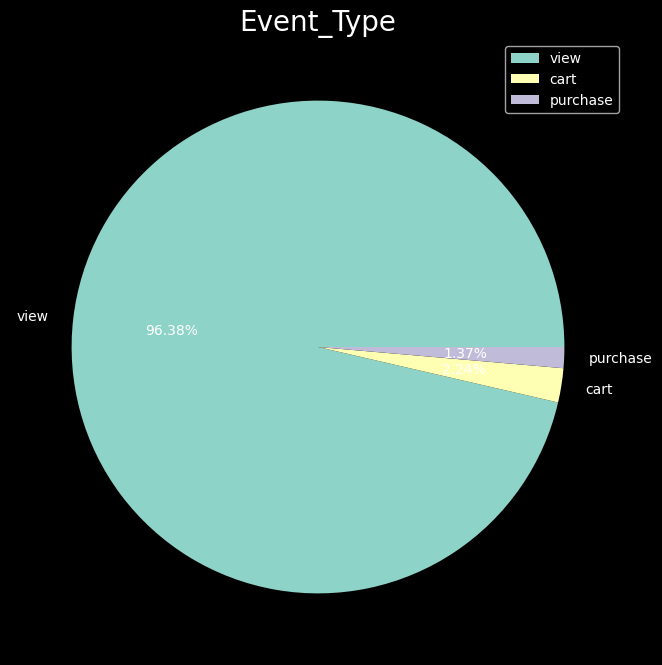

In [9]:
event_types = silver_df.groupBy("event_type").count().orderBy("count", ascending=False)
pd_event_types = event_types.toPandas()

plt.rcParams["figure.figsize"] = (8, 8)
plt.pie(pd_event_types["count"], labels=pd_event_types["event_type"], autopct="%.2f%%")
plt.title("Event_Type", fontsize=20)
plt.axis("off")
plt.legend()
plt.show()

In [ ]:
df_cart_purchase_events = silver_df.filter(
    f.col("event_type").isin(["cart", "purchase"])
).dropDuplicates(["event_type", "product_id", "price", "user_id", "user_session"])

df_cart_purchase_events = df_cart_purchase_events.withColumn(
    "is_purchased", f.when(f.col("event_type") == "purchase", 1).otherwise(0)
)

session_product_window = Window.partitionBy("user_session", "product_id")
df_cart_purchase_events = df_cart_purchase_events.withColumn(
    "is_purchased", f.max("is_purchased").over(session_product_window)
)

df_cart_only_events = df_cart_purchase_events.filter(
    f.col("event_type") == "cart"
).dropDuplicates(["user_session", "product_id", "is_purchased"])

df_cart_only_events = df_cart_only_events.withColumn(
    "event_weekday", f.weekofyear("event_time")
)

df_cart_only_events = df_cart_only_events.dropna()

df_cart_only_events = df_cart_only_events.withColumn(
    "category_level_1", f.split(f.col("category_code"), "\\.")[0]
).withColumn("category_level_2", f.split(f.col("category_code"), "\\.")[1])

df_cart_only_events = df_cart_only_events.withColumn(
    "category_level_1", f.col("category_level_1").cast("string")
).withColumn("category_level_2", f.col("category_level_2").cast("string"))

df_cart_only_events.write.format("parquet").mode("overwrite").save("./stage/targets")
df_cart_only_events.show()

+-------------------+----------+----------+-------------------+--------------------+-------+------+---------+--------------------+------------+-------------+--------------------+--------------------+
|         event_time|event_type|product_id|        category_id|       category_code|  brand| price|  user_id|        user_session|is_purchased|event_weekday|category_code_level1|category_code_level2|
+-------------------+----------+----------+-------------------+--------------------+-------+------+---------+--------------------+------------+-------------+--------------------+--------------------+
|2019-11-03 07:44:22|      cart|   4802161|2053013554658804075|electronics.audio...|    jbl|  8.21|513335704|0002aa56-9237-445...|           0|           44|         electronics|               audio|
|2019-11-08 11:08:29|      cart|   1005099|2053013555631882655|electronics.smart...|samsung|138.11|565674659|0002b8f8-5045-4a3...|           1|           45|         electronics|          smartphone|


In [12]:
cart_purchase_users = silver_df.filter(
    f.col("event_type").isin(["cart", "purchase"])
).select("user_id").distinct()

cart_purchase_users = cart_purchase_users.dropna()

cart_purchase_users_all_activity = silver_df.join(
    cart_purchase_users, "user_id"
)

In [ ]:
activity_in_session = cart_purchase_users_all_activity.groupBy("user_session").agg(
    f.count("event_type").alias("activity_count")
)
activity_in_session.write.format("parquet").mode("overwrite").save(
    "./stage/activity_in_session"
)

activity_in_session.show()

+--------------------+--------------+
|        user_session|activity_count|
+--------------------+--------------+
|12f77848-604b-406...|             6|
|1976f3ba-55cc-434...|             1|
|1cf4b9e5-e23d-49d...|             6|
|34225dfc-f300-4a5...|             1|
|34616653-0c6e-418...|             4|
|37e60dfa-b62c-4b7...|             7|
|3e0fcbe1-ac1f-4bd...|             2|
|3f3f9929-25b0-499...|             7|
|40724260-9c62-49d...|             4|
|037efc83-8d92-43f...|             7|
|0c5a9504-9b54-45e...|            10|
|12cff895-587b-4a7...|             4|
|21206795-859e-4e9...|             9|
|215d290e-44af-495...|             9|
|2a35db9e-33f1-41d...|            20|
|3847904a-8a67-4dc...|             4|
|3c0830d3-525d-4f7...|             8|
|3e151501-7652-480...|             1|
|0bcb14d1-c474-40c...|             1|
|0bd66ba2-fe33-456...|             4|
+--------------------+--------------+
only showing top 20 rows



In [ ]:
df_cart_purchase_targets = spark.read.format("parquet").load("./stage/targets")

df_session_activity = spark.read.format("parquet").load("./stage/activity_in_session")

df_cart_purchase_targets = df_cart_purchase_targets.join(
    df_session_activity, "user_session", "left"
)

df_cart_purchase_targets = df_cart_purchase_targets.withColumn(
    "activity_count", f.coalesce(f.col("activity_count"), f.lit(0))
)

df_cart_purchase_targets.show()

+------------------------------------+-------------------+----------+----------+-------------------+-----------------------------------+--------+-------+---------+------------+-------------+--------------------+--------------------+--------------+
|user_session                        |event_time         |event_type|product_id|category_id        |category_code                      |brand   |price  |user_id  |is_purchased|event_weekday|category_code_level1|category_code_level2|activity_count|
+------------------------------------+-------------------+----------+----------+-------------------+-----------------------------------+--------+-------+---------+------------+-------------+--------------------+--------------------+--------------+
|00060054-401d-4d35-8bd7-d2580b73a3f0|2019-11-09 13:40:23|cart      |3600835   |2053013563810775923|appliances.kitchen.washer          |samsung |656.36 |565817990|1           |45           |appliances          |kitchen             |14            |
|000a23c